# Classification task for first population

In [2]:
#Data processing
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.figure_factory as ff

#Plotting
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#Analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Common Model Algorithms
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier, RandomTreesEmbedding
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

#Machine Learning
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn import tree

#Helpers
from sklearn import model_selection

%matplotlib inline

In [3]:
df_normed = pd.read_csv('/Users/duc_hoang/Box Sync/Fermilab Summer Research/Analysis_Scripts/Main data/Jesse_data/normalized_all_Jesse_simple_attributes.csv', index_col = 0)

In [4]:
df_normed.columns

Index(['initial_accuracy', 'final_accuracy', 'genealogy', 'net_depth_avg',
       'num_conv_layers', 'num_pooling_layers', 'avg_IP_neurons',
       'avg_IP_weights', 'avg_split_width', 'avg_concat_width',
       'avg_num_conv_features', 'prop_conv_into_pool', 'prop_pool_into_pool',
       'prop_1x1_conv', 'prop_square_kernels', 'prop_horiz_kernels',
       'prop_vert_kernels', 'num_relu', 'num_sigmoid',
       'avg_grid_reduction_area_consecutive',
       'avg_grid_reduction_height_consecutive',
       'avg_grid_reduction_width_consecutive', 'avg_grid_reduction_area_total',
       'avg_grid_reduction_height_total', 'avg_grid_reduction_width_total',
       'prop_nonoverlapping', 'avg_stride_h', 'avg_stride_w',
       'avg_ratio_features_to_depth', 'avg_ratio_features_to_kerArea',
       'avg_ratio_features_to_kerWidth', 'avg_ratio_features_to_kerHeight',
       'avg_ratio_kerArea_to_depth', 'avg_ratio_kerWidth_to_depth',
       'avg_ratio_kerHeight_to_depth'],
      dtype='object')

In [5]:
#get normalized independent features (excluding accuracies and geneology)
X_normed = df_normed.drop(columns=['initial_accuracy','final_accuracy', 'genealogy'])

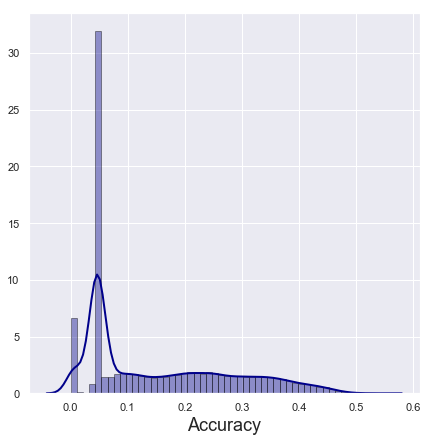

In [8]:
#histogram
fig = plt.figure(figsize=[7,7])
fig1 = sns.distplot(df_normed["final_accuracy"],
                    hist=True, kde=True, 
                    color = 'darkblue',
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth': 2}, norm_hist=True);
fig1.set_xlabel("Accuracy", fontsize = 18)
plt.savefig('Accuracy_distribution_2.png')